In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *
from test_function import test
from NN_classes import *

index exceeds number of initial conditions -> random value chosen


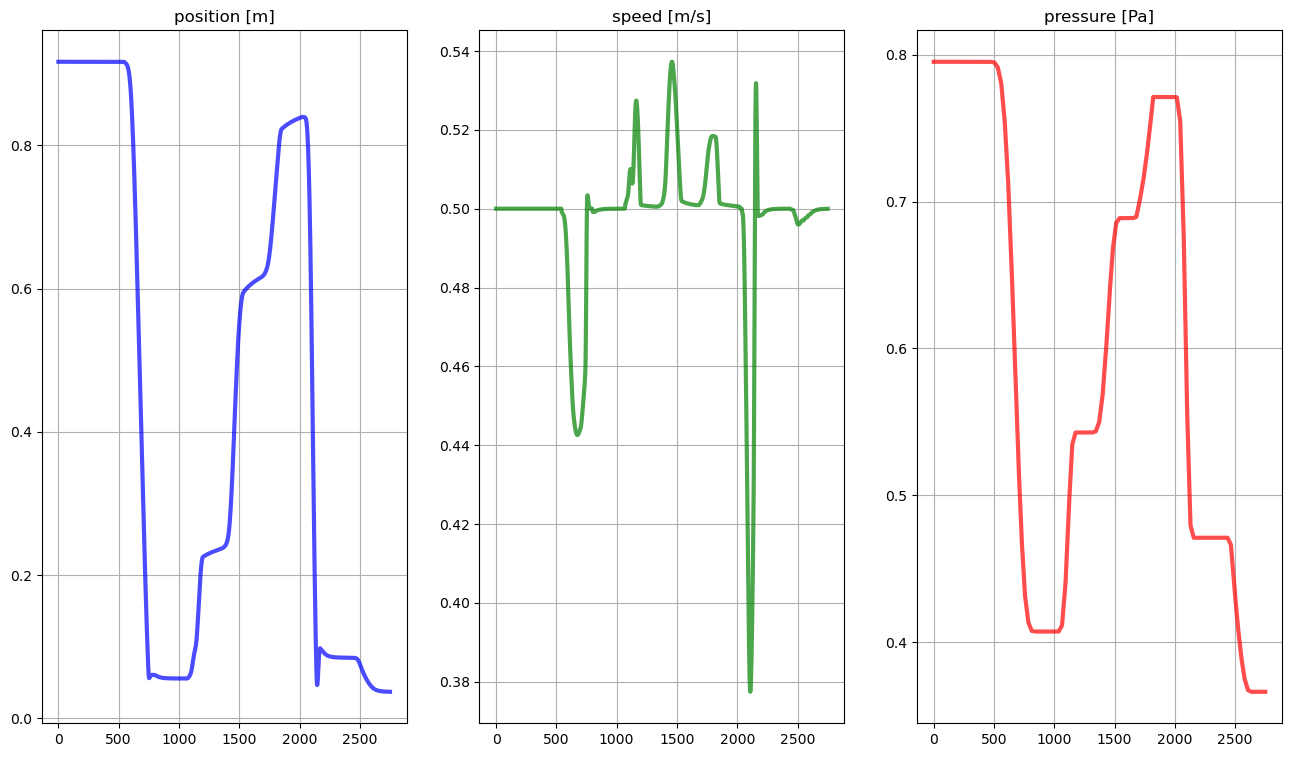

In [2]:
# Import the data generated via matlab/simulink:

# see get_data.py for more info

#save_data_test_revised.csv

data_tensor, PSW_max = get_data(path = r"data\save_data_test_5xlonger.csv", timesteps_from_data=0,
                                 skip_steps_start = 0, skip_steps_end = 0, drop_half_timesteps = True, normalise_s_w="minmax", rescale_p=False, num_inits=0)

# View an example of a simulation run
visualise(data_tensor, num_inits=2000)

In [3]:
from torch.utils.data import Dataset, DataLoader

class custom_simple_dataset(Dataset):

    def __init__(self, data, window_size):

        self.data = data
        self.ws = window_size

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):

        inp = self.data[idx, :, :]
        label = self.data[idx, self.ws:, 1:]

        return inp, label


# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

cpu


In [4]:

def fr(v):

#parBoost_gen.d_b  = 3.2;                    % Dämpfungskonste Booster in [Ns/m]  Update AP: 2021Feb alter Wert 33.184
#parBoost_gen.F_c  = 0.5;                      % Coulombreibkraft Booster in [N] Update AP: 2021Feb alter Wert: 1.53;

    d = 3.2
    F_c  = 0.5

    fr = - d * v - F_c * torch.sign(v)


    return fr

def fk(s,v):

# % Paramter Kontaktmodell
# % Unterer Anschlag
# parBoost_gen.c_bwl = 166e3;          % Federkonstante unterer Anschlag in [N/m]
# parBoost_gen.d_bwl = 474;            % Dämpfungskonstante unterer Anschlag in [Ns/m]
# parBoost_gen.s_0bwl = 0.3e-4;        % Kontaktpunkt unterer Anschlag in [m] 
# % Oberer Anschlag
# parBoost_gen.c_bwu = 166e3;                         % Federkonstante oberer Anschlag in [N/m]
# parBoost_gen.d_bwu = 474;                           % Dämpfungskonstante oberer Anschlag in [Ns/m]
# parBoost_gen.s_0bwu = parBoost_gen.s_b_max - 0.12e-4;     % Kontaktpunkt oberer Anschlag in [m]
#parBoost_gen.s_b_max = 0.6e-3;                                      % Maximaler Hub in [m]

    s_u =  0.6e-3 - 0.12e-4
    c_u = 166e3
    d_u = 474

    c_l = 166e3
    s_l =  0.3e-4
    d_l = 474


    if s_u <= s:
        
        fk = -c_u * (s - s_u) - d_u * v * (s - s_u)

    elif s <= s_l:

        fk = c_l * (s - s_l) - d_l * v * (s - s_l)

    else:
        fk = 0

    return fk

def ODE_right_side(x, pressure, physics_rescaling=None):

    #rescale to physical units

   # x[:, :,0] = x[:, :,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
   # x[:, :,1] = x[:, :,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
   # pressure[:, :,0] = pressure[:, :,0]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

    x_dt = torch.zeros_like(x[:,:,0:1]) # write s' = v (v from real data)  
    #          v'  = 1/m ( A * ( p - p0) - c * (s - s0) + fr(v) + fk(s,v) )  

    # andere Formulierung: fs = -(c_b*s_b - F_cb0) statt -c_b *(s_b - s_0b);

    #          v'  = 1/m ( A * ( p - p0) - (c_b*s_b - F_cb0) + fr(v) + fk(s,v) )  


    m = 1.8931e-3                         # 1.8931e-3;              % Masse Booster in [kg]
    A = 0.5*(71.0526e-6 + 78.9793e-6 )  # 0.5*(parBoost_gen.A_b_closed + parBoost_gen.A_b_open);   % Mittlere Fläche Booster in [m²]                                
                                            # % Anfangswerte der Boostereinheit
    p0 = 1e5                                # parBoost_gen.s_b_0 = 3e-4;
    s0 = 3e-4                               # parBoost_gen.p_b_0 = 1e5;
    c = 16.5e3                              # parBoost_gen.c_b  = 16.5e3;                 % Federkonstante Booster in [N/m]
    F_cb0 = -4.3                            #parBoost_gen.F_cb0 = -4.3;                    % Federvorspannkraft (Kraft der Feder bei sb=0) [N]


    for i in range(x_dt.size(dim=0)):
        for time in range(x_dt.size(dim=1)):

            p = pressure[i, time, 0] * (physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]
            s =  x[i, time, 0] * (physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
            v = x[i, time, 1] * (physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]

            x_dt[i, time, 0:1] =  1/m * ( A * ( p - p0) - (c * s - F_cb0) + fr(v) + fk(s,v) ) 

    return x_dt

def train(input_data, model, weight_decay, learning_rate=0.001, ws=0, PSW_max=0, physics_loss_weight = 0.0001):
 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
 
    model.train()
    total_loss = []
    total_physics_loss = []

    # s' = v
    # v' = f(s,v,p)
    # 
    # (s,v) = model return (we can also return the derivatives calculated by the model!)
    #
    # (s,v), (s', v') = model (return are vectors len = timesteps modulo init values)
    #  
    #  physic_error = 1/len * sum( mse ( (s', v') - (v, f(s,v,p))  ))
    #
    #  def f(s,v, p) from matlab (bad with normalisation!!!)
    #

    for k, (x,y) in enumerate(input_data):  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)
        
        output, _, derivative_sv = model(x)

        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(output, y)

        # calc physics loss
        physics_loss=0
        if physics_loss_weight != 0:
        
         pressure = x[:, ws:, 0:1] # Anfangswerte sind abgeschnitten weil len(output) == len(x) - windowsize 
         assert pressure.size(dim=1) == output.size(dim=1)
         physics_loss = physics_loss_weight * loss_fn(ODE_right_side(output, pressure, PSW_max), ODE_right_side(y, pressure, PSW_max))
         
        losses = loss + physics_loss

        losses.backward()
        optimizer.step()
 
        total_loss.append(loss.detach().cpu().numpy())
        total_physics_loss.append(physics_loss.detach().cpu().numpy())
   # return the average error of the next step prediction

   
    return np.mean(total_loss), np.mean(total_physics_loss)

In [5]:

params =           {
                           "experiment_number" : 2,
                           "window_size" : 16,
                           "h_size" : 8,
                           "l_num" : 1,
                           "epochs" : 100,
                           "learning_rate" : 0.001,
                           "part_of_data" : 50, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.3,
                           "future_decay"  : 0.5,
                           "batch_size" : 2,
                           "future" : 10,
                           "cut_off_timesteps" : 300,
                           "drop_half_timesteps": True,
                           "physics_loss_weight" : 0.001
                        }

# Initialize the LSTM model
model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"], rungekutta=False).to(device)
# Generate input data (the data is normalized and some timesteps are cut off)
input_data1, PSW_max = get_data(path = "data\save_data_test_5xlonger.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

# input_data2, PSW_max = get_data(path = "save_data_test5.csv", 
#                         timesteps_from_data=0, 
#                         skip_steps_start = 0,
#                         skip_steps_end = 0, 
#                         drop_half_timesteps = params["drop_half_timesteps"],
#                         normalise_s_w="minmax",
#                         rescale_p=False,
#                         num_inits=params["part_of_data"])

# input_data3, PSW_max = get_data(path = "Testruns_from_trajectory_generator_t2_t6_revised.csv", 
#                         timesteps_from_data=0, 
#                         skip_steps_start = 0,
#                         skip_steps_end = 0, 
#                         drop_half_timesteps = params["drop_half_timesteps"],
#                         normalise_s_w="minmax",
#                         rescale_p=False,
#                         num_inits=params["part_of_data"])

input_data = input_data1#torch.cat((input_data1, input_data2, input_data3))
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set = custom_simple_dataset(train_data, window_size=params["window_size"])
train_loader = DataLoader(train_set, batch_size=params["batch_size"], pin_memory=True)

losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(params["epochs"])):
    
    loss_epoch, loss_physics = train(train_loader, model, params["weight_decay"], learning_rate= params["learning_rate"],
                        ws=params["window_size"], PSW_max = PSW_max, physics_loss_weight=params["physics_loss_weight"])
    losses.append(loss_epoch)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%2 == 0:    

        print("Train loss:", loss_epoch)
        print("physics loss:", loss_physics)

        _,_, err_train = test(input_data, model, model_type = "or_lstm", window_size=params["window_size"], display_plots=False,
                               num_of_inits = 20, set_rand_seed=True, physics_rescaling = PSW_max)

        average_traj_err_train.append(err_train)
        #average_traj_err_test.append(err_test)
        print(f"Epoch: {e}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
                #print(f"Average error over full trajectories: testing data : {err_test}")

_,_, err_test = test(input_data, model, model_type = "or_lstm", window_size=params["window_size"], display_plots=False, num_of_inits = 1, set_rand_seed=True, physics_rescaling = PSW_max)
#_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
#print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
        

torch.Size([50, 2750, 3])


  0%|          | 0/100 [00:04<?, ?it/s]


KeyboardInterrupt: 

input_data size torch.Size([50, 2750, 3])


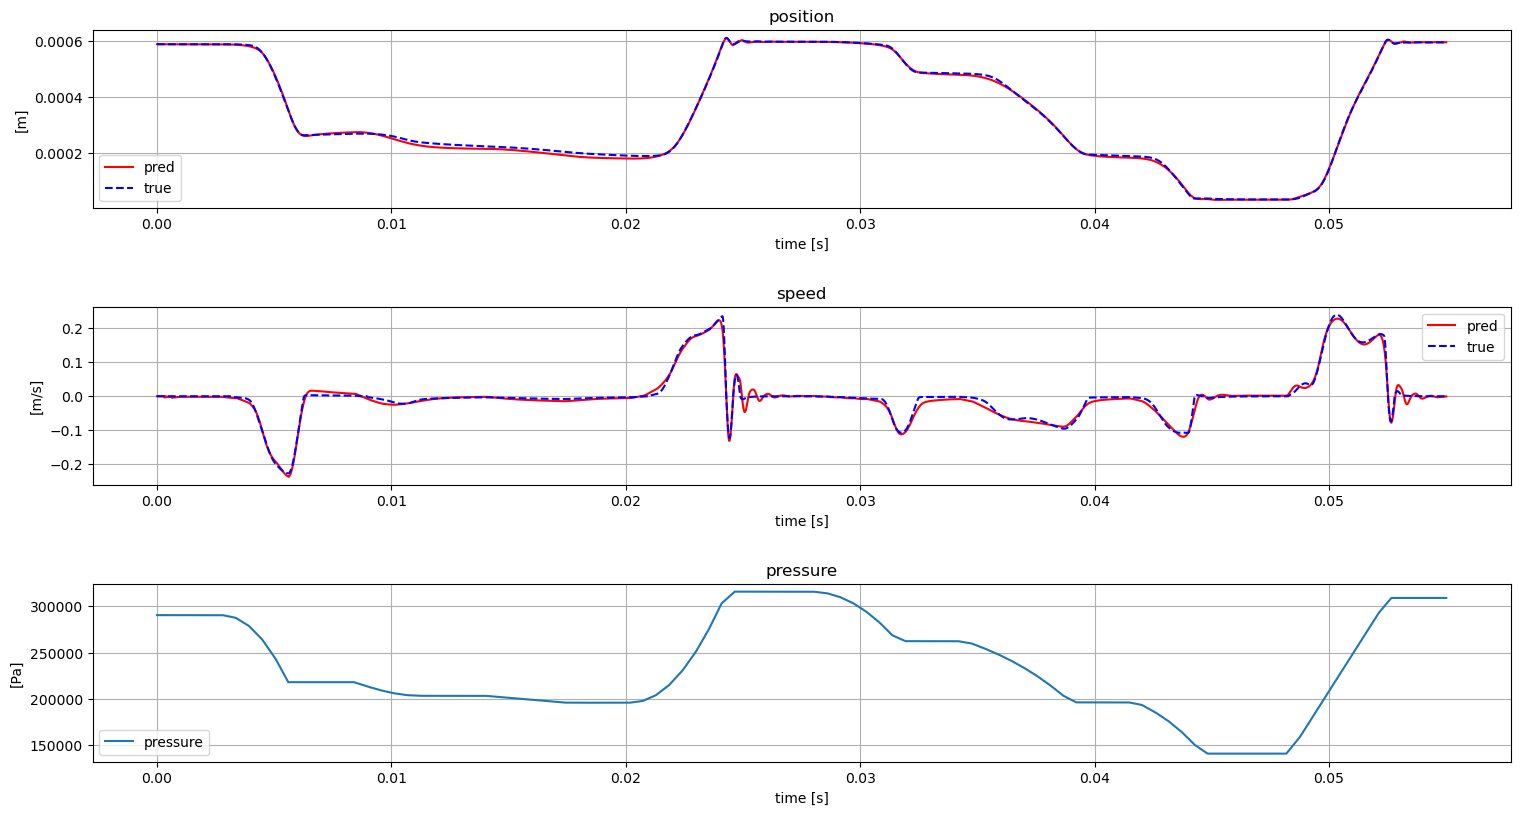

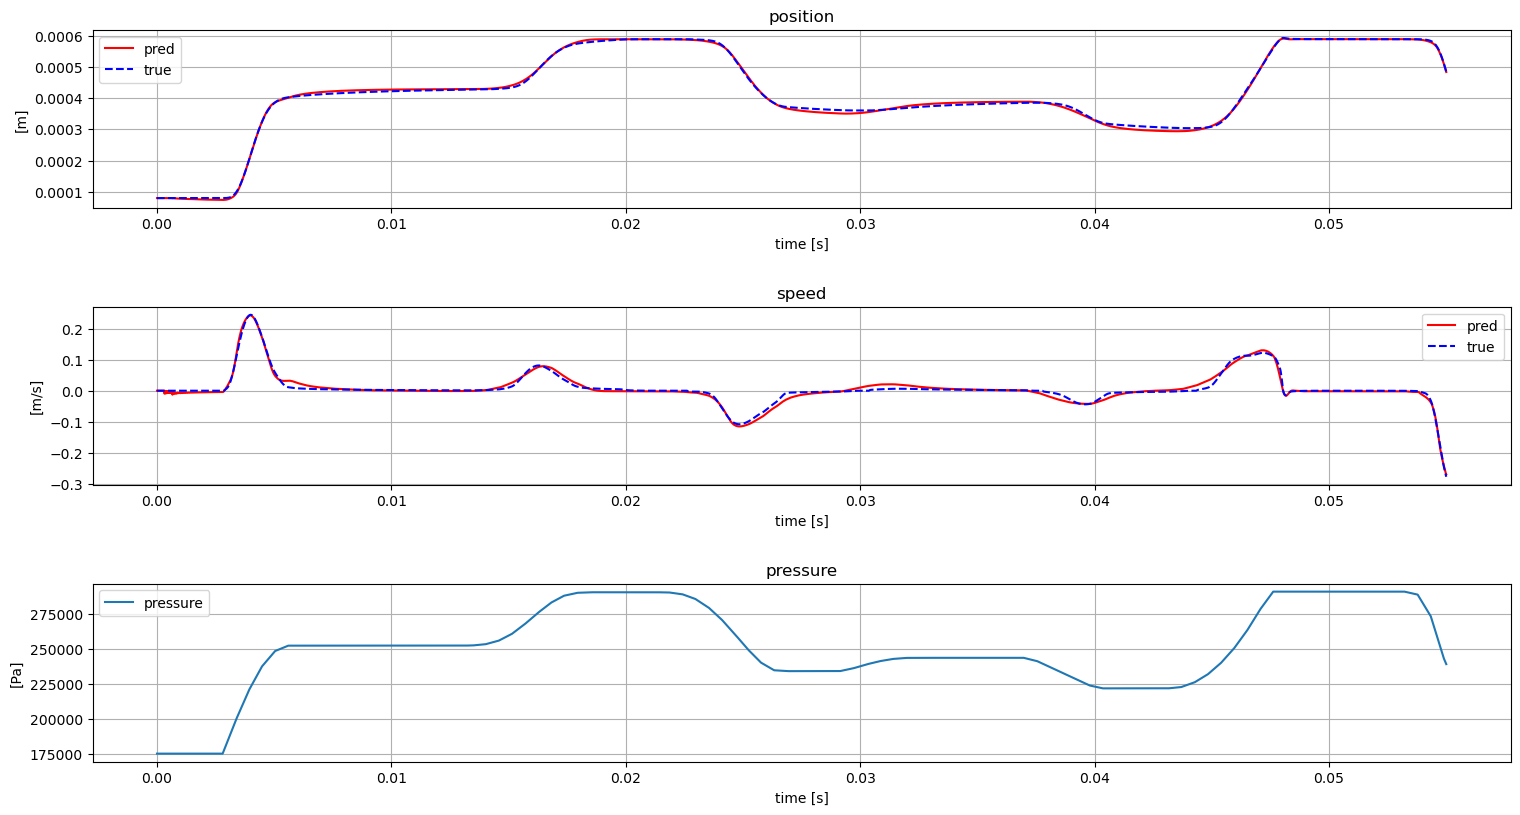

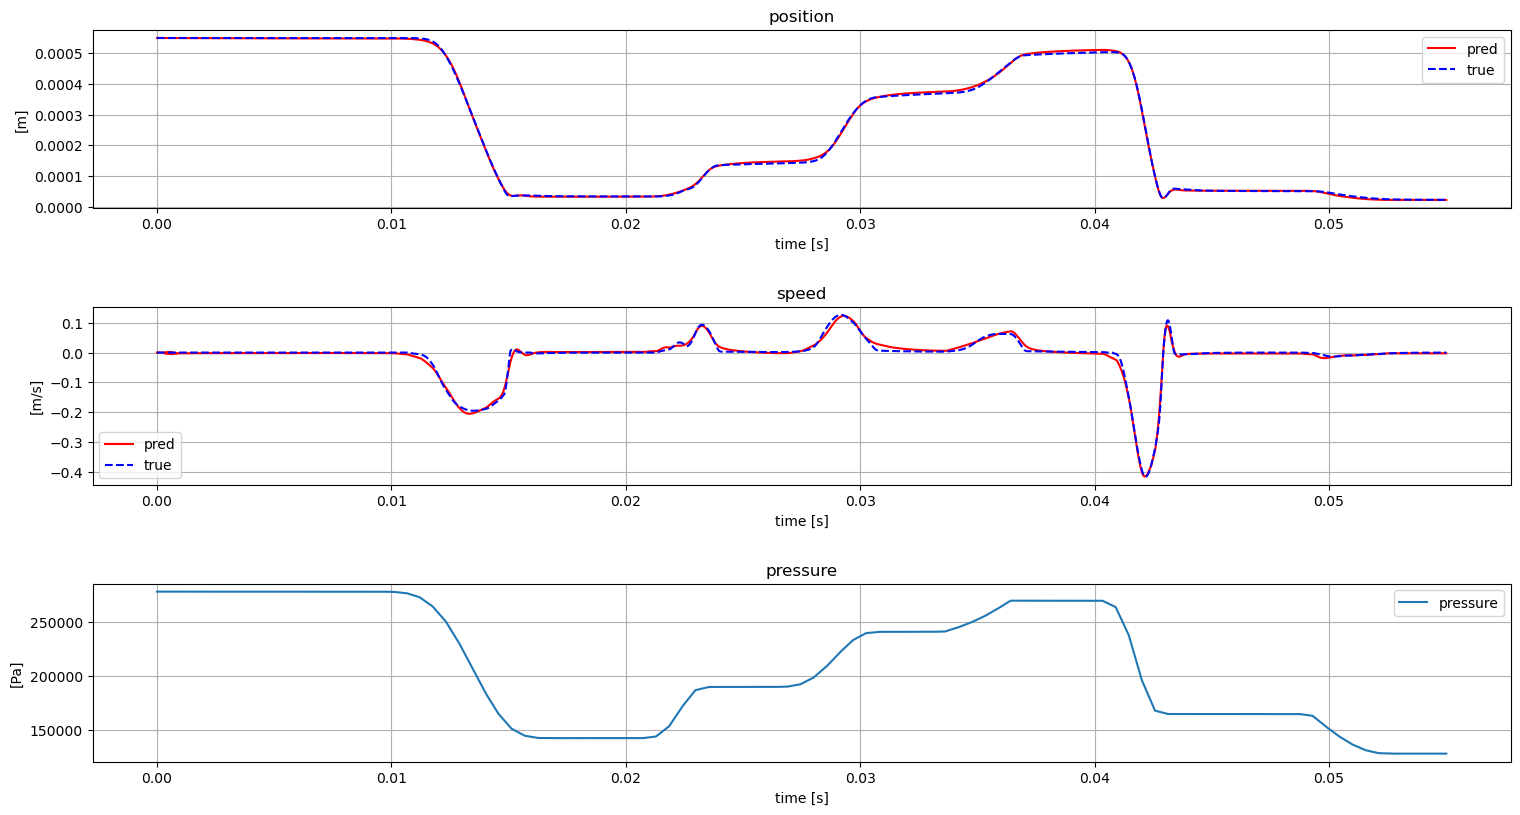

In [6]:
# Save the model
# path = f"Ventil_trained_NNs\lstm_ws0.pth"
# #
# torch.save(model.state_dict(), path)

# Load the model and test it on the test data
path = "working_networks\OR_lstm_16_8_3_best_V2.pth"

params =                 {
                           "experiment_number" : 2,
                           "window_size" : 16,
                           "h_size" : 8,
                           "l_num" : 3,
                           "epochs" : 3000,
                           "learning_rate" : 0.0008,
                           "part_of_data" : 0, 
                           "weight_decay" : 0,
                           "percentage_of_data" : 0.8,
                           "future_decay"  : 0.5,
                           "batch_size" : 20,
                           "future" : 10,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True
                        }



input_data1, PSW_max = get_data(path = "data\save_data_test_5xlonger.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "data\save_data_test5.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data3, PSW_max = get_data(path = "data\Testruns_from_trajectory_generator_t2_t6_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])
                        

#input_data = torch.cat((input_data1, input_data2, input_data3))
input_data=input_data1
np.random.seed(1234)
print("input_data size", input_data.size())
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
test_data = input_data[test_inits,:,:]
np.random.seed()

# Initialize the LSTM model

model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"], stepsize=1, rungekutta=False)

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

train_data = input_data[train_inits,:,:]
#%matplotlib qt 
#%matplotlib inline 

#test_loss, test_loss_deriv, total_loss, physloss
test_loss, test_loss_deriv, total_loss = test(test_data, model, model_type = "or_lstm", window_size=params["window_size"],
                                                         display_plots=True, num_of_inits = 3, set_rand_seed=False, physics_rescaling = PSW_max, additional_data=None)
#test_loss, test_loss_deriv, total_loss = test(train_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 1,  test_inits=len(test_data), rand=False, PSW_max=0)

#[350000.0, 0.0006, 1.7, 0.0, 0.0, -1.7]

input_data size torch.Size([400, 550, 3])


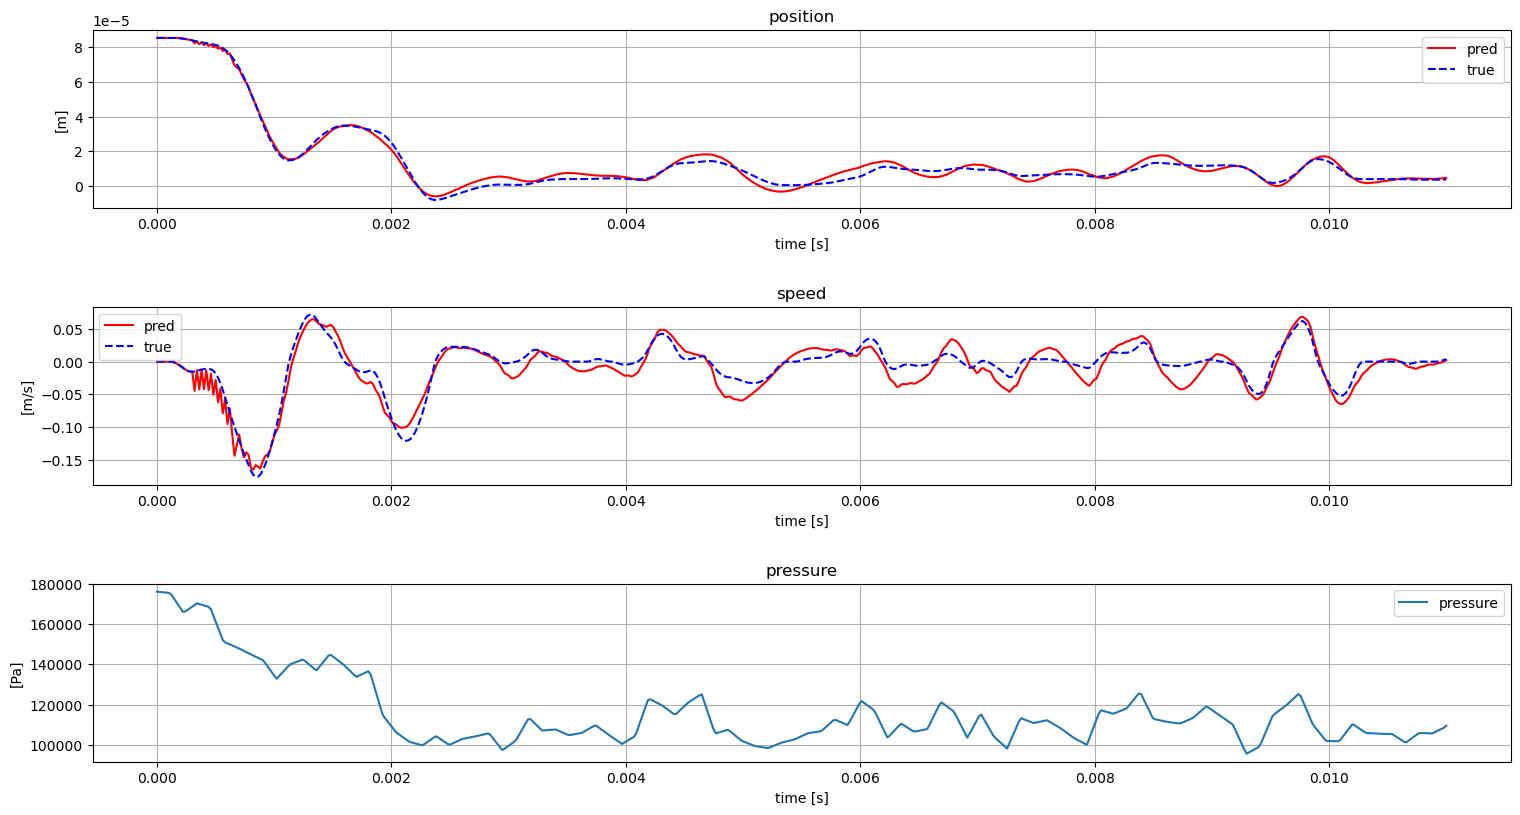

In [7]:
# Save the model
# path = f"Ventil_trained_NNs\lstm_ws0.pth"
# #
# torch.save(model.state_dict(), path)
 
# Load the model and test it on the test data
path = "working_networks\OR_lstm_16_8_3_best_V2.pth"
 
params =                 {
                           "experiment_number" : 2,
                           "window_size" : 16,
                           "h_size" : 8,
                           "l_num" : 3,
                           "epochs" : 3000,
                           "learning_rate" : 0.0008,
                           "part_of_data" : 0,
                           "weight_decay" : 0,
                           "percentage_of_data" : 0.8,
                           "future_decay"  : 0.5,
                           "batch_size" : 20,
                           "future" : 10,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True
                        }
 
 
 
input_data1, PSW_max = get_data(path = "data\save_data_test_5xlonger.csv",
                        timesteps_from_data=0,
                        skip_steps_start = 0,
                        skip_steps_end = 0,
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])
 
input_data2, PSW_max = get_data(path = "data\save_data_test_revised.csv",
                        timesteps_from_data=0,
                        skip_steps_start = 0,
                        skip_steps_end = 0,
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])
 
input_data3, PSW_max = get_data(path = "data\Testruns_from_trajectory_generator_t2_t6_revised.csv",
                        timesteps_from_data=0,
                        skip_steps_start = 0,
                        skip_steps_end = 0,
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])
                       
 
#input_data = torch.cat((input_data1, input_data2, input_data3))
input_data = input_data2

 
np.random.seed(1234)
print("input_data size", input_data.size())
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
test_data = input_data[test_inits,:,:]
np.random.seed()
 
# Initialize the LSTM model
 
model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"], stepsize=1, rungekutta=False)
 
model.load_state_dict(torch.load(path, map_location=torch.device(device)))
 
train_data = input_data[train_inits,:,:]
#%matplotlib qt
#%matplotlib inline
 
#test_loss, test_loss_deriv, total_loss, physloss
test_loss, test_loss_deriv, total_loss = test(test_data, model, model_type = "or_lstm", window_size=params["window_size"],
                                                         display_plots=True, num_of_inits = 1, set_rand_seed=False, physics_rescaling = PSW_max, additional_data=None)
#test_loss, test_loss_deriv, total_loss = test(train_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 1,  test_inits=len(test_data), rand=False, PSW_max=0)
 
#[350000.0, 0.0006, 1.7, 0.0, 0.0, -1.7]

In [8]:
# Anzahl parameter im Modell

import torch
from torchviz import make_dot
from IPython.display import Image

print(input_data2[0:1,0:17,:].size())

print(list(model.parameters()))

#calc 
erg=0
for a in list(model.parameters()):
    x = 1 
    for y in list(a.size()):
        x = x*y
    erg += x

print("anzahl der variablen" , erg)


torch.Size([1, 17, 3])
[Parameter containing:
tensor([[-0.2793,  1.0003,  0.1417],
        [-0.7859, -0.5780, -0.2464],
        [ 0.3008,  0.0043, -0.1727],
        [ 0.2013,  0.2139, -0.0425],
        [-0.6430, -0.3283, -0.1388],
        [-0.6202,  0.2818, -0.1555],
        [-0.3708, -0.5195, -0.2290],
        [ 0.6562,  0.9567,  0.5780],
        [-0.5647, -0.2422, -0.4876],
        [-0.2358, -0.6777,  0.0825],
        [ 0.5532,  0.1443,  0.3546],
        [ 0.6744, -0.0851,  0.5059],
        [-0.7032, -0.2564, -0.2196],
        [-0.0477, -0.1437,  0.2029],
        [-0.3160, -0.4538,  0.2156],
        [ 0.3761, -0.0973, -0.2894],
        [-0.2440,  0.7412, -0.5844],
        [ 0.0804,  1.2348,  0.0290],
        [ 0.6669, -0.3218,  0.2017],
        [-0.1819,  0.5393,  0.4914],
        [-0.1758,  0.2883, -0.0927],
        [ 0.0329,  1.1104, -0.1309],
        [ 0.2289, -0.0209,  0.1666],
        [-0.2944,  0.0883,  0.9424],
        [ 0.0573,  0.8944, -0.4413],
        [-0.4640, -0.2240,  0